<a href="https://colab.research.google.com/github/abhilb/Open-eye-closed-eye-classification/blob/main/part2/MRL_Eye_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
tf.__version__

'2.7.0'

In [3]:
input_img = Input(shape=(64,64,1), name="input")
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv4')(encoded)
x = UpSampling2D((2, 2), name='upsample1')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv5')(x)
x = UpSampling2D((2, 2), name='upsample2')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6')(x)
x = UpSampling2D((2, 2), name='upsample3')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoder")(x)

autoencoder = Model(input_img, decoded, name="eye_autoencoder")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
autoencoder.summary()

Model: "eye_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 16)        4624      
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 16)        2320      
                                                                 
 encoder (MaxPooling2D)      (None, 8, 8, 16)      

In [5]:
encoded.shape

TensorShape([None, 8, 8, 16])

In [6]:
!gdown https://drive.google.com/uc?id=1w0e2KZbca2emoJ_VV7zdUEkHN1JHjkAW

Downloading...
From: https://drive.google.com/uc?id=1w0e2KZbca2emoJ_VV7zdUEkHN1JHjkAW
To: /content/mrl_dataset_64.npz
100% 2.78G/2.78G [00:21<00:00, 129MB/s]


In [7]:
dataset_path = Path('mrl_dataset_64.npz').absolute().resolve()
data = np.load(str(dataset_path))
X = data['data']
y = data['labels']
data.close()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of samples in training dataset: {X_train.shape[0]}")
print(f"Number of samples in testing dataset : {X_test.shape[0]}")

Number of samples in training dataset: 56881
Number of samples in testing dataset : 28017


In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
X_train = np.reshape(X_train, (X_train.shape[0], 64, 64, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 64, 64, 1))
print(X_train.shape)
print(X_test.shape)

(56881, 64, 64, 1)
(28017, 64, 64, 1)


In [11]:
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
445/445 [==============================] - 37s 62ms/step - loss: 0.0299 - val_loss: 0.0104
Epoch 2/50
445/445 [==============================] - 27s 60ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 3/50
445/445 [==============================] - 27s 61ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 4/50
445/445 [==============================] - 28s 63ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 5/50
445/445 [==============================] - 26s 58ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/50
445/445 [==============================] - 27s 60ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 7/50
445/445 [==============================] - 26s 58ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 8/50
445/445 [==============================] - 26s 58ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 9/50
445/445 [==============================] - 26s 58ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 10/50
445/445 [==============================] - 27s 60ms/step - loss: 0.010

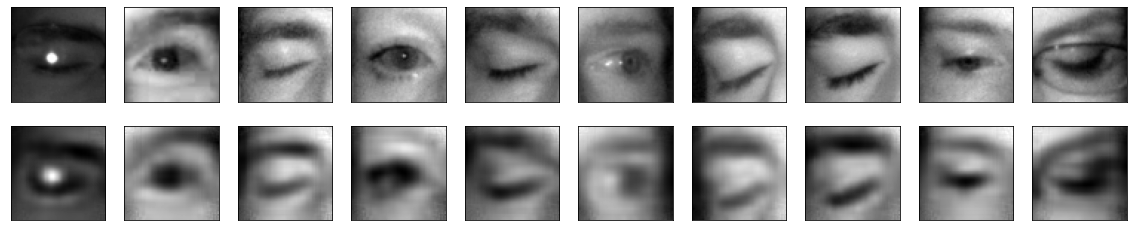

In [13]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()